In [1]:
from cmt_vna import calkit as cal
import numpy as np
import matplotlib.pyplot as plt
import os
import eigsep_observing as obs
%matplotlib notebook

In [2]:
LAB_OSL_MEAS_DIR = 'cable_measurements_0813'

def lin2dB(data):
    return 20*np.log10(np.abs(data))

In [3]:
for i in sorted(os.listdir(LAB_OSL_MEAS_DIR)):
    file = os.path.join(LAB_OSL_MEAS_DIR, i)
    data = np.load(file)
    freqs = data['freqs']
    print(data.keys())
kit = cal.S911T(freq_Hz=freqs)

KeysView(NpzFile 'cable_measurements_0813/20250813_155051_vna_data.npz' with keys: rf_cables, ant_cables, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250813_155612_vna_data.npz' with keys: vnaport, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250813_155829_vna_data.npz' with keys: vnaport, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250813_161614_vna_data.npz' with keys: rfant, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250813_162207_vna_data.npz' with keys: antenna_cables, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250815_141255_vna_data.npz' with keys: vnaport_S911T, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250815_145029_vna_data.npz' with keys: vnaport_S911T, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250815_145643_vna_data.npz' with keys: vnaport_S911T, freqs)
KeysView(NpzFile 'cable_measurements_0813/20250818_093413_vna_data.npz' with keys: ns_cables, rfn_cables, freqs)


# in-lab cable s-parameter measurements

First, we find the sparameters of the VNA+coax using the S911T standards. Calibrating these parameters out of other measurements brings the calibration plane to just before the switch port. 

From this, we can characterize the OSL that are attached to the switch network and consistently measured, allowing us to compare the measurement to expectation and find the sparameters of the VNA+coax system for each of the OSL measurements.

NOTE: These VNA+coax S-parameters are only used to characterize the OSL standards, and the OSL standards as characterized here will be used to find the VNA+coax S-parameters from data taken in the field.

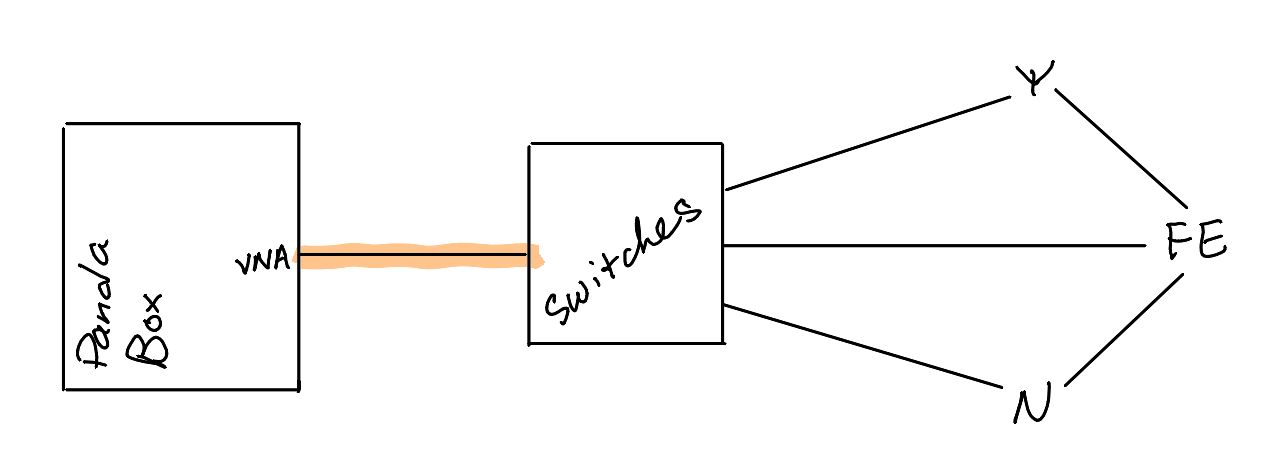

In [4]:
from IPython.display import Image
Image(filename='vnaport.png')

<IPython.core.display.Javascript object>


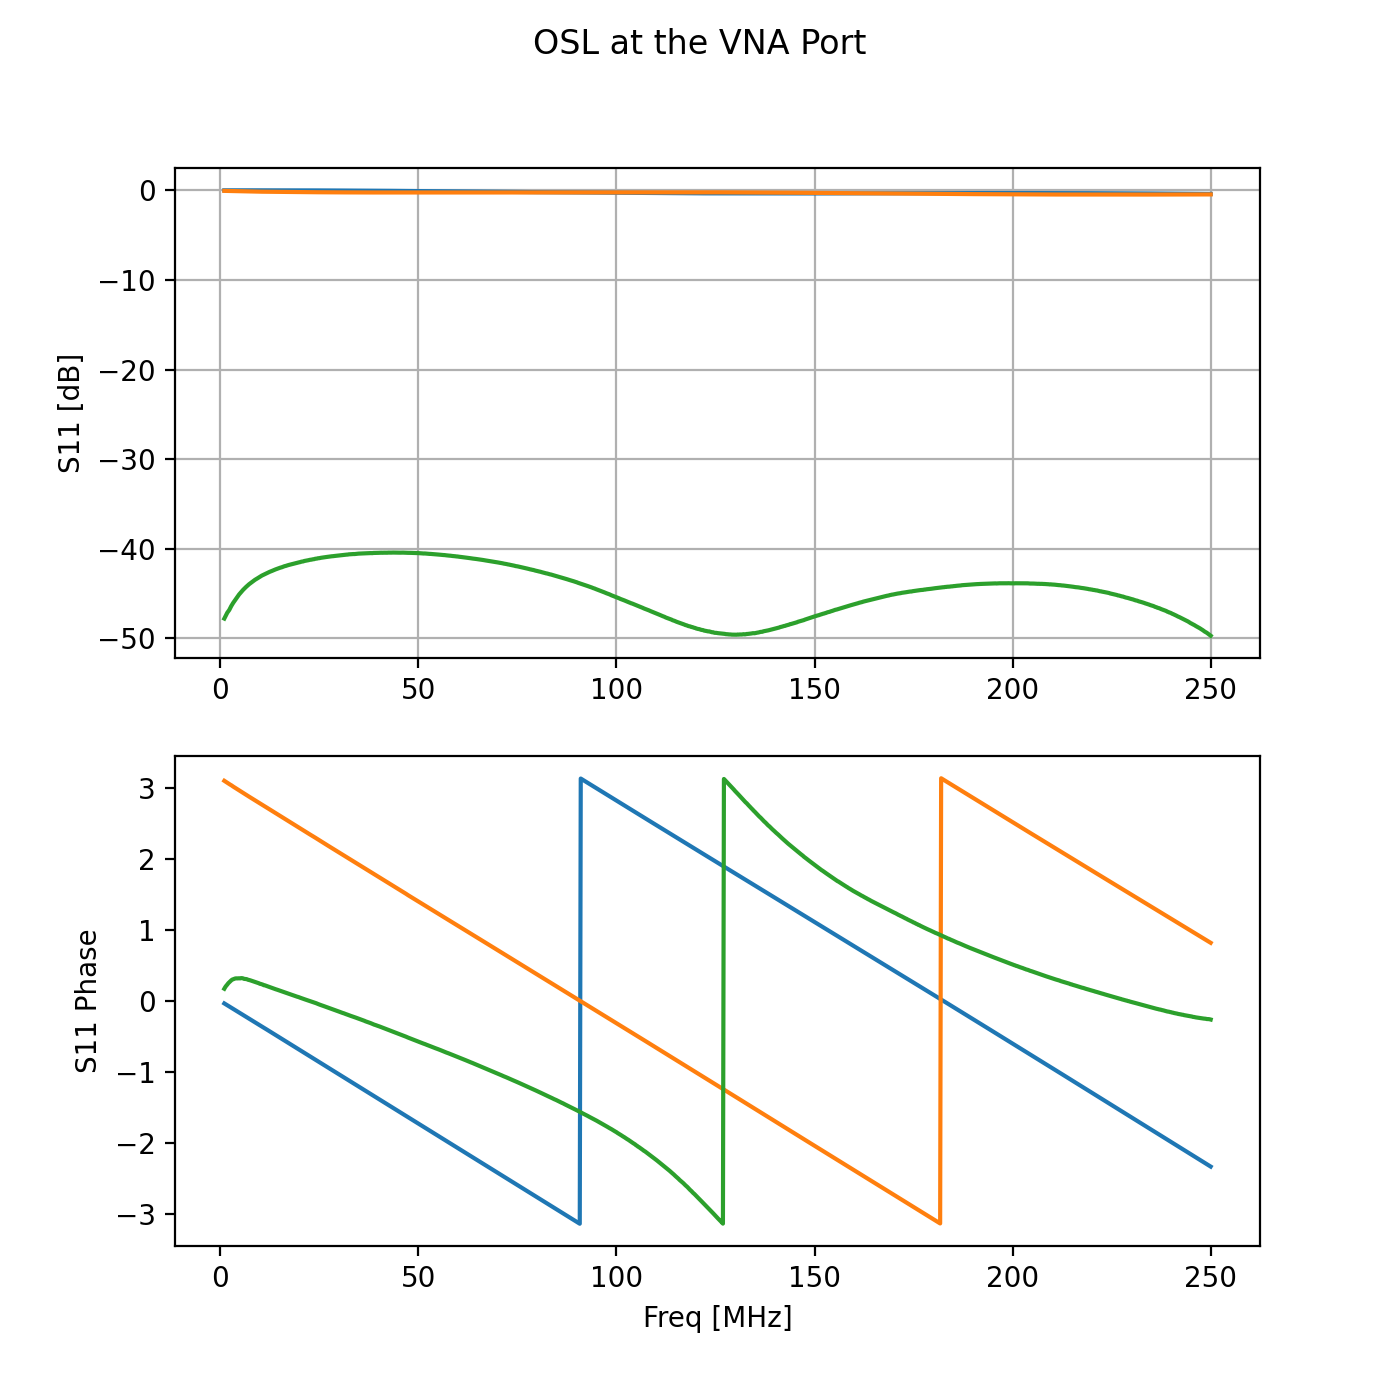

<IPython.core.display.Javascript object>


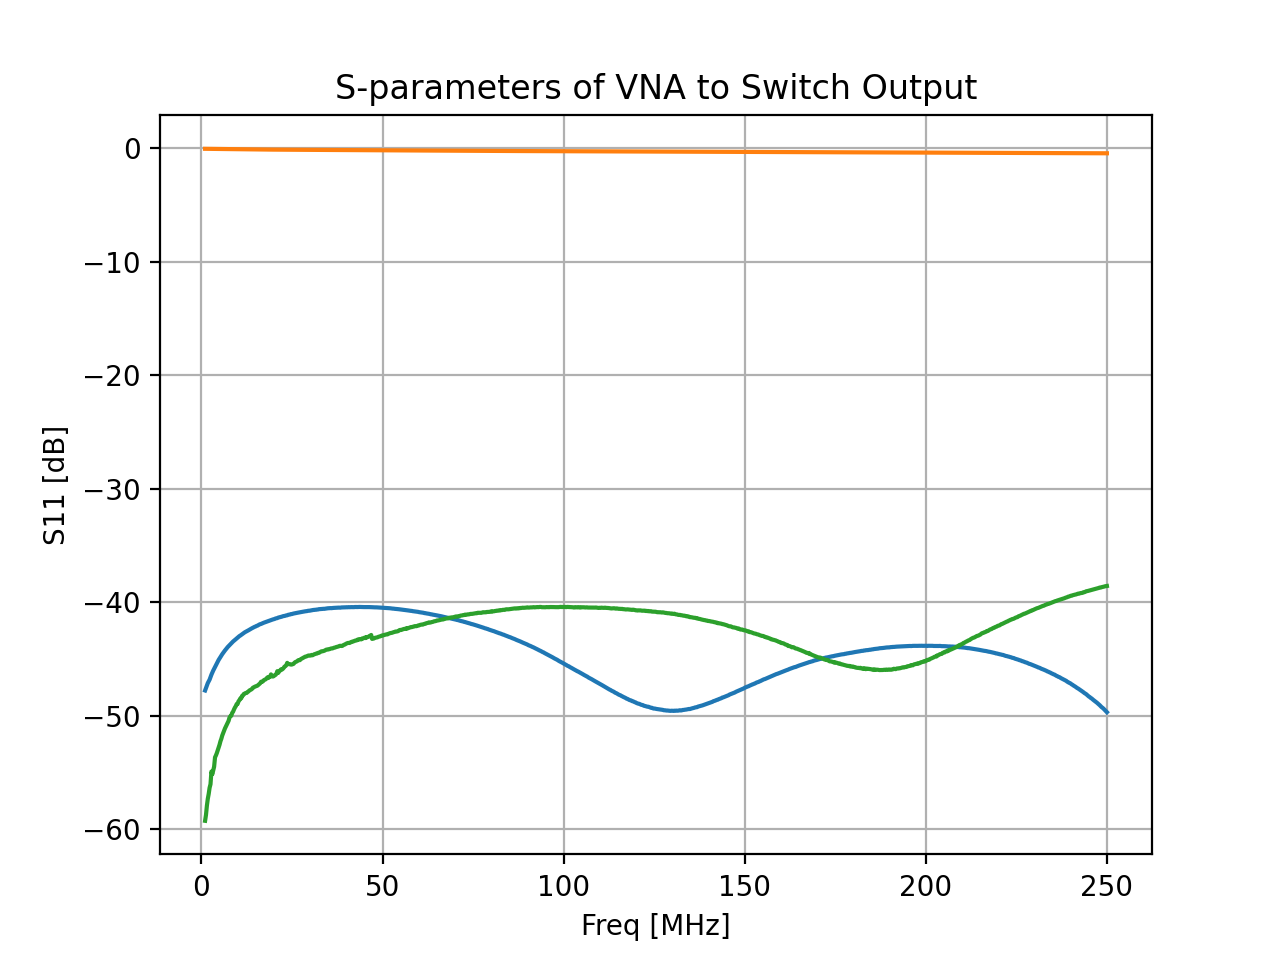

In [6]:
###CABLE BETWEEN VNA AND SWITCHES, CALIBRATED TO S911T STANDARDS###
vnaport = np.load('cable_measurements_0813/20250815_145643_vna_data.npz')['vnaport_S911T']

fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7))
ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

# plt.suptitle('OSL at the VNA Port \n NOT S911T')
plt.suptitle('OSL at the VNA Port')
ax.plot(freqs/1e6, lin2dB(vnaport.T))
ay.plot(freqs/1e6, np.angle(vnaport).T)
plt.show()

vna_sprms = kit.sparams(vnaport)
plt.figure()
plt.title('S-parameters of VNA to Switch Output')
plt.xlabel('Freq [MHz]')
plt.ylabel('S11 [dB]')
plt.plot(freqs/1e6, lin2dB(vna_sprms.T))
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


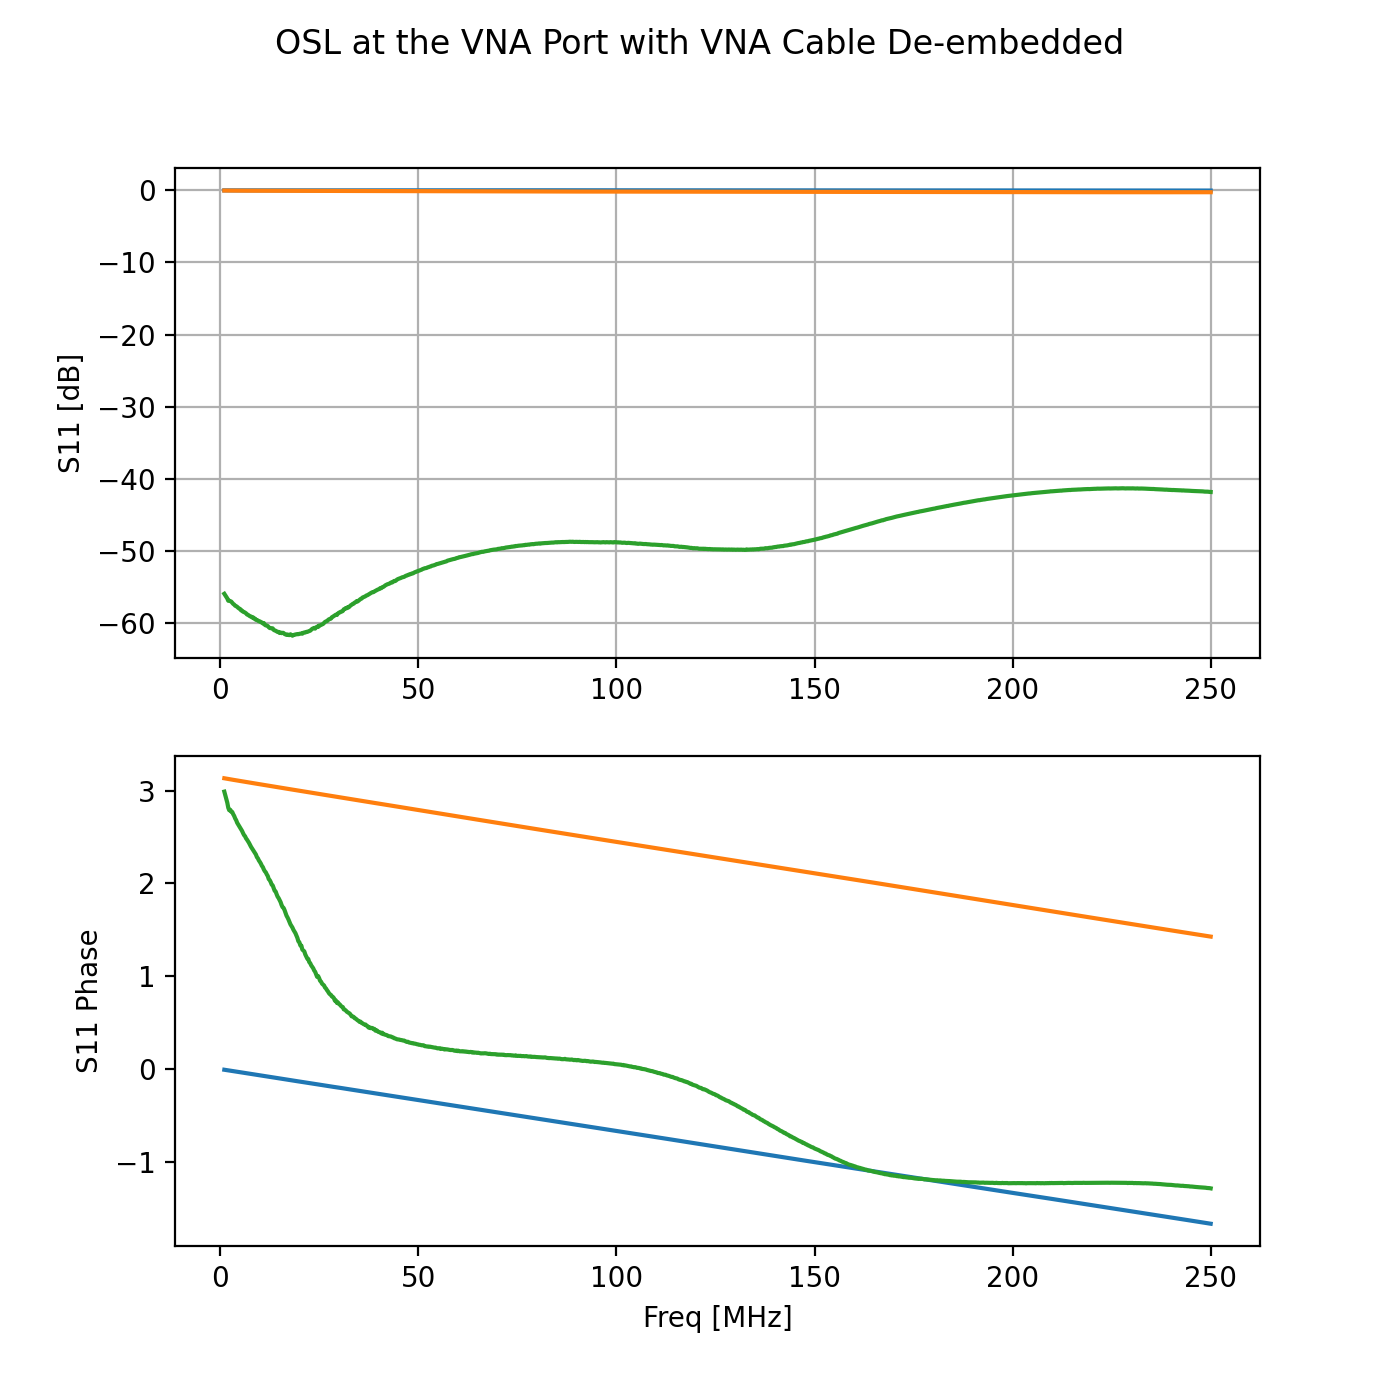

In [7]:
#These are not the S911T standards, these are the standards directly attached to the switch. 
#Characterizing these gives us standards to compare field measurements to.
uncal_switch_stds = np.load('cable_measurements_0813/20250813_155829_vna_data.npz')['vnaport']
switch_stds = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=uncal_switch_stds) #Data driven standards
data_kit = cal.CalKit(freq_Hz=freqs, Z0=50)#initialize a new CalKit object, gonna manually add the correct gammas
data_kit.std_gamma = switch_stds #This is the important attribute I think
fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7))
ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

plt.suptitle('OSL at the VNA Port with VNA Cable De-embedded')
ax.plot(freqs/1e6, lin2dB(switch_stds.T))
ay.plot(freqs/1e6, np.angle(switch_stds).T)
plt.show()

np.savez('fieldOSL_characterizations.npz', fieldOSL=data_kit.std_gamma)

# Finding sparameters of the components of the system.
Will have to de-embed the vnaport sparams from all the following OSL measurements, and then find the cable sparams from those OSLs.

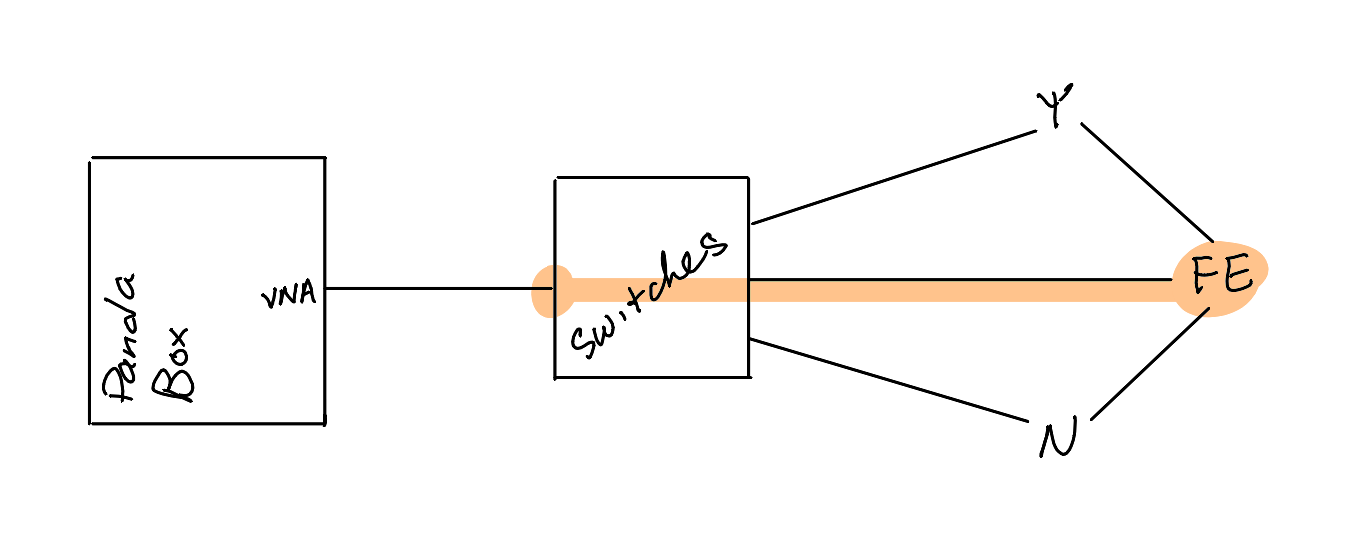

In [8]:
###CABLES BETWEEN FRONT END AND VNA###
from IPython.display import Image
Image(filename='rf_cables.png')

<IPython.core.display.Javascript object>


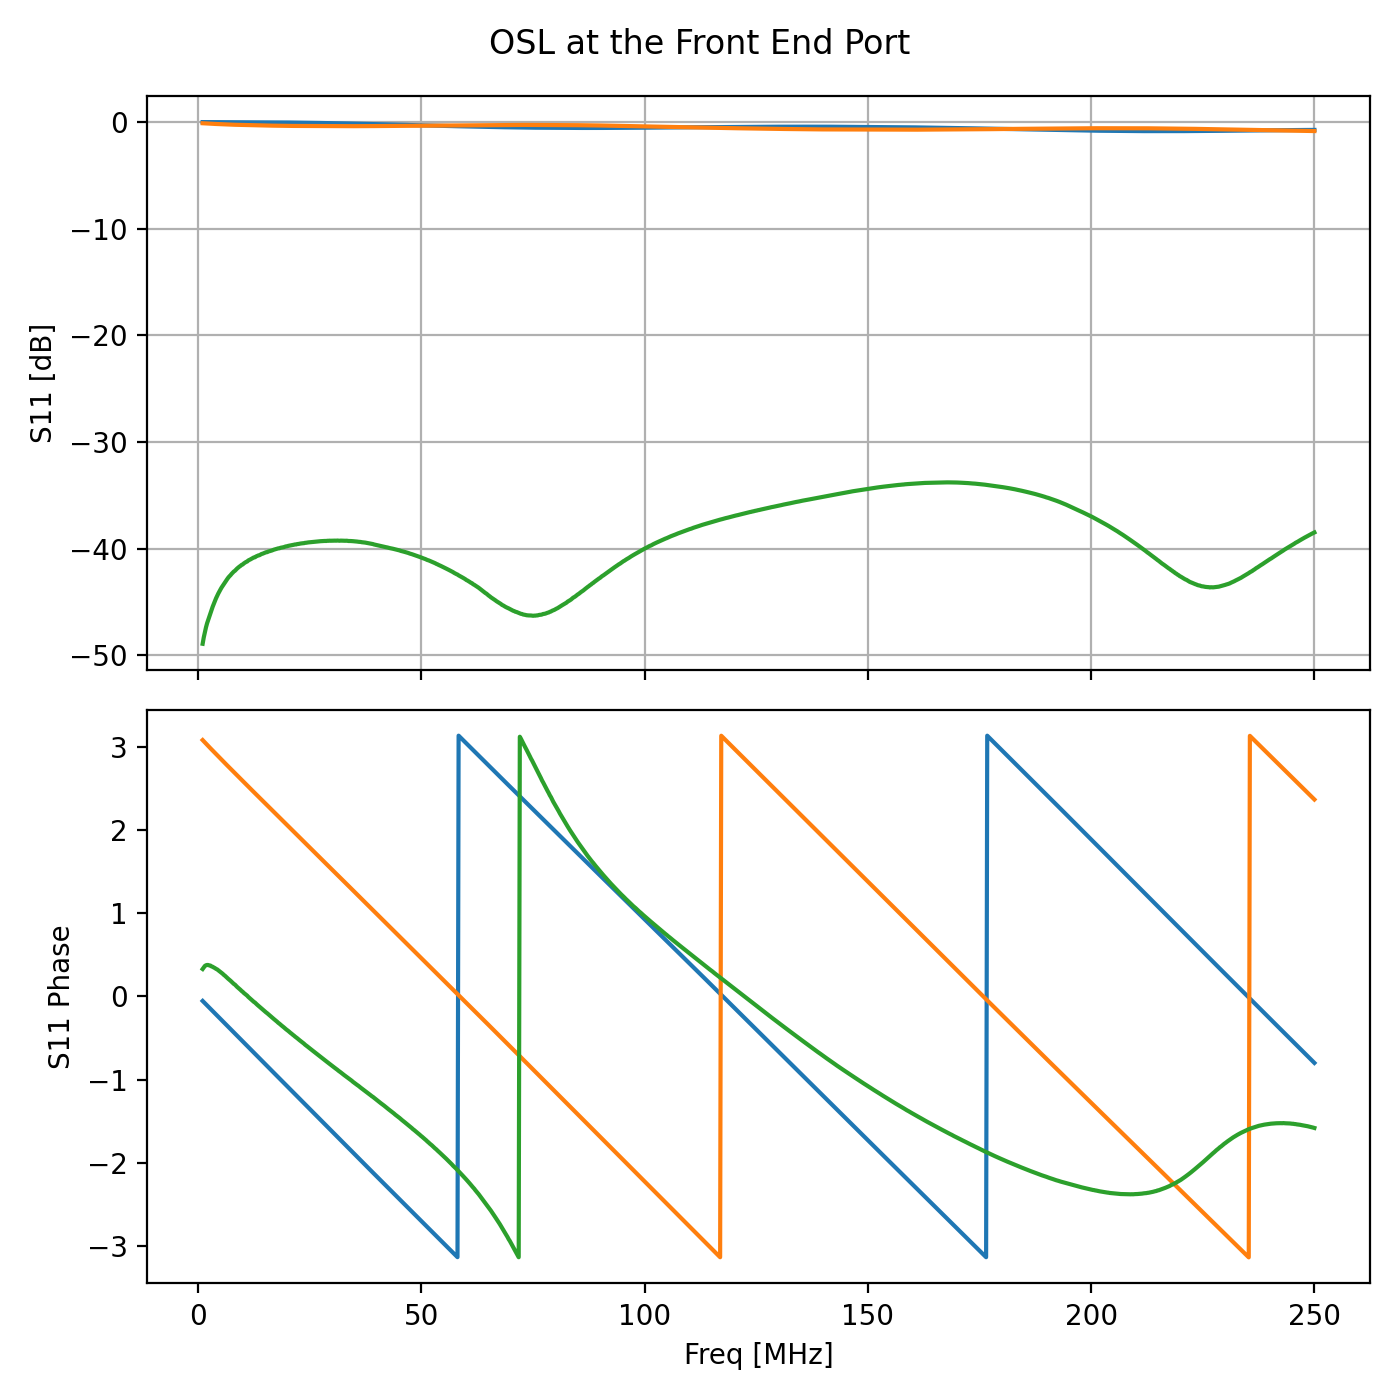

<IPython.core.display.Javascript object>


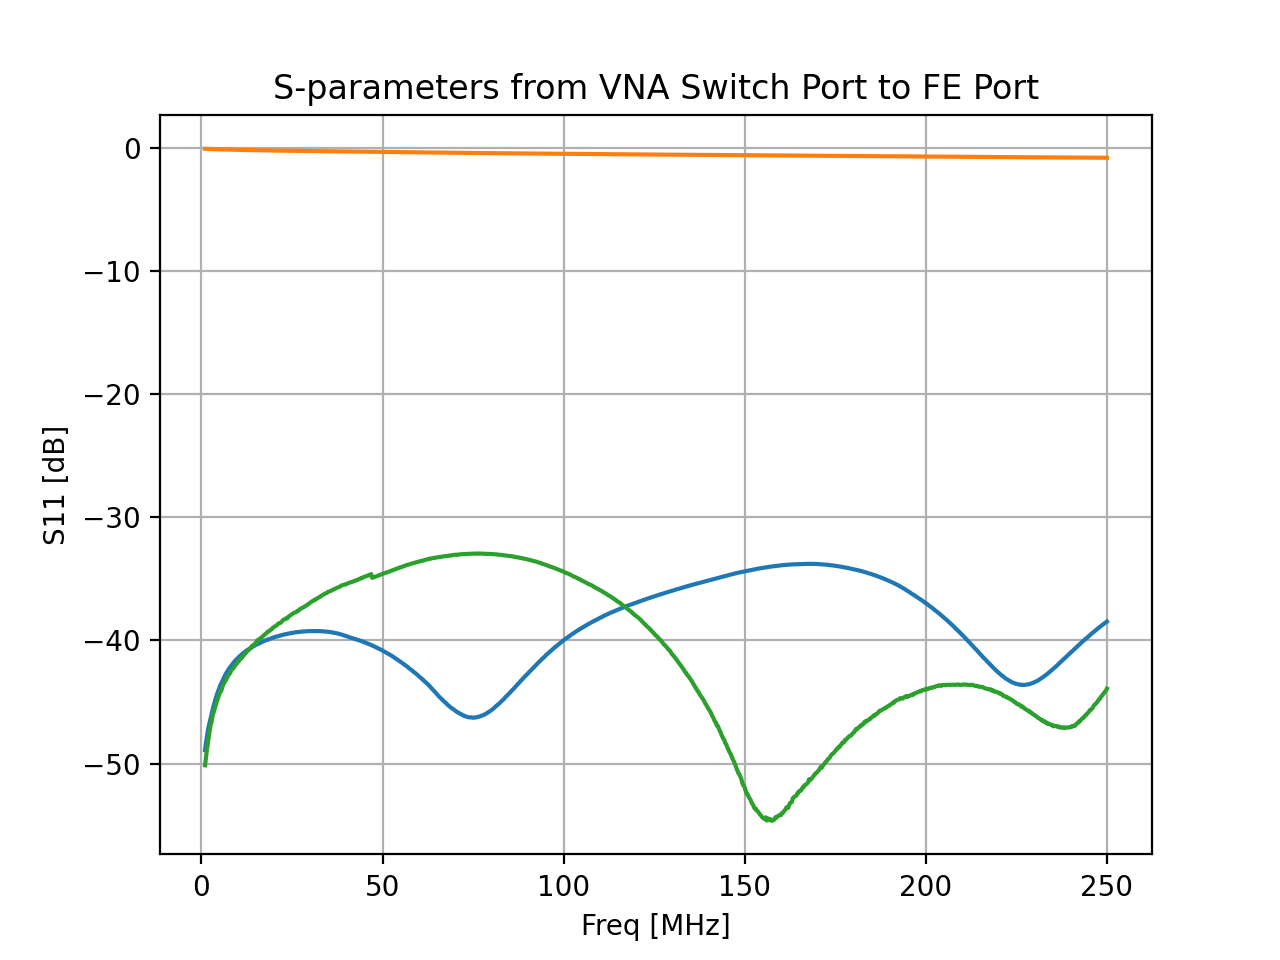

In [9]:
rf_data = np.load('cable_measurements_0813/20250813_155051_vna_data.npz')
rf_cables = rf_data['rf_cables']
rf_cables = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=rf_cables)
fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7),sharex=True)

ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

plt.suptitle('OSL at the Front End Port')

ax.plot(freqs/1e6, lin2dB(rf_cables.T))
ay.plot(freqs/1e6, np.angle(rf_cables).T)
plt.tight_layout()
plt.show()

rf_cables_sprms = kit.sparams(rf_cables)
plt.figure()
plt.title('S-parameters from VNA Switch Port to FE Port')
plt.xlabel('Freq [MHz]')
plt.ylabel('S11 [dB]')
plt.grid()
plt.plot(freqs/1e6, lin2dB(rf_cables_sprms.T))
plt.show()

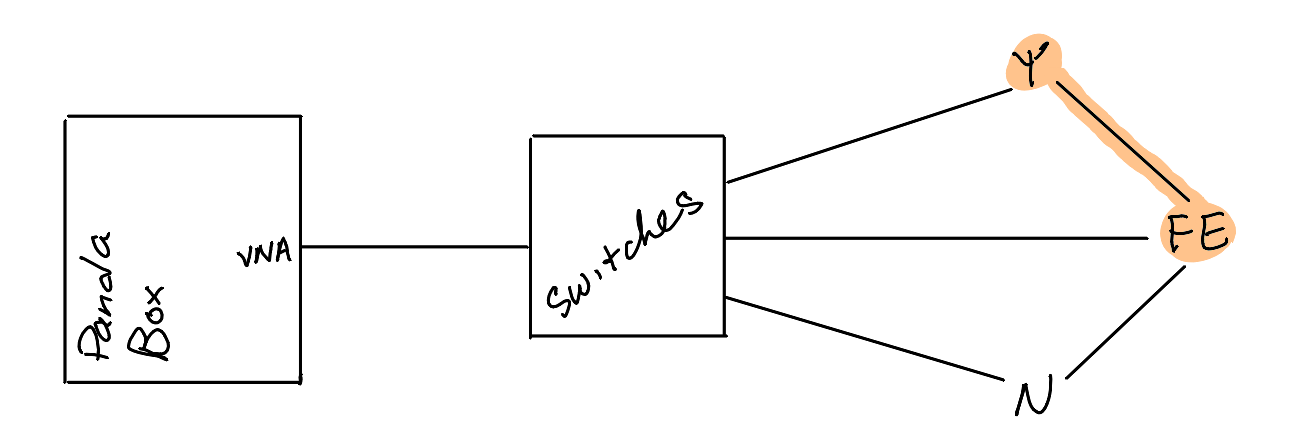

In [10]:
###CABLES BETWEEN FRONT END AND FEED###
from IPython.display import Image
Image(filename='rfant_cables.png')

<IPython.core.display.Javascript object>


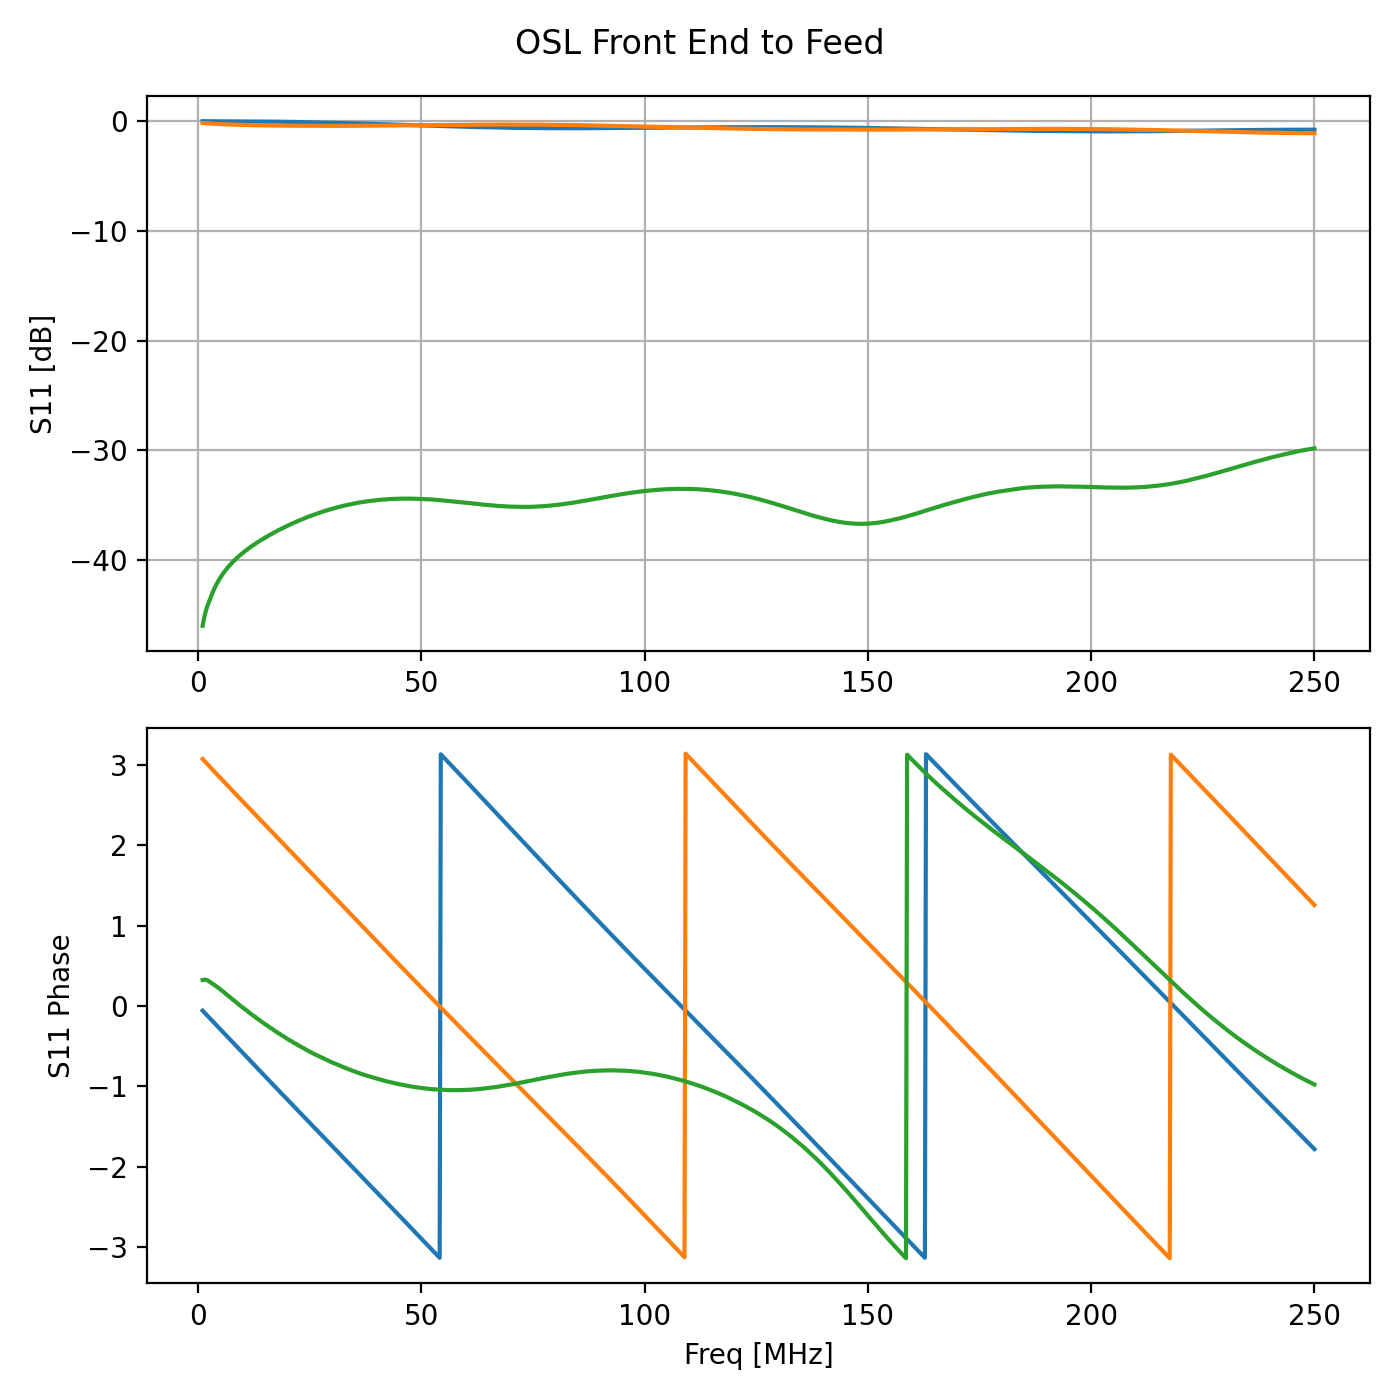

<IPython.core.display.Javascript object>


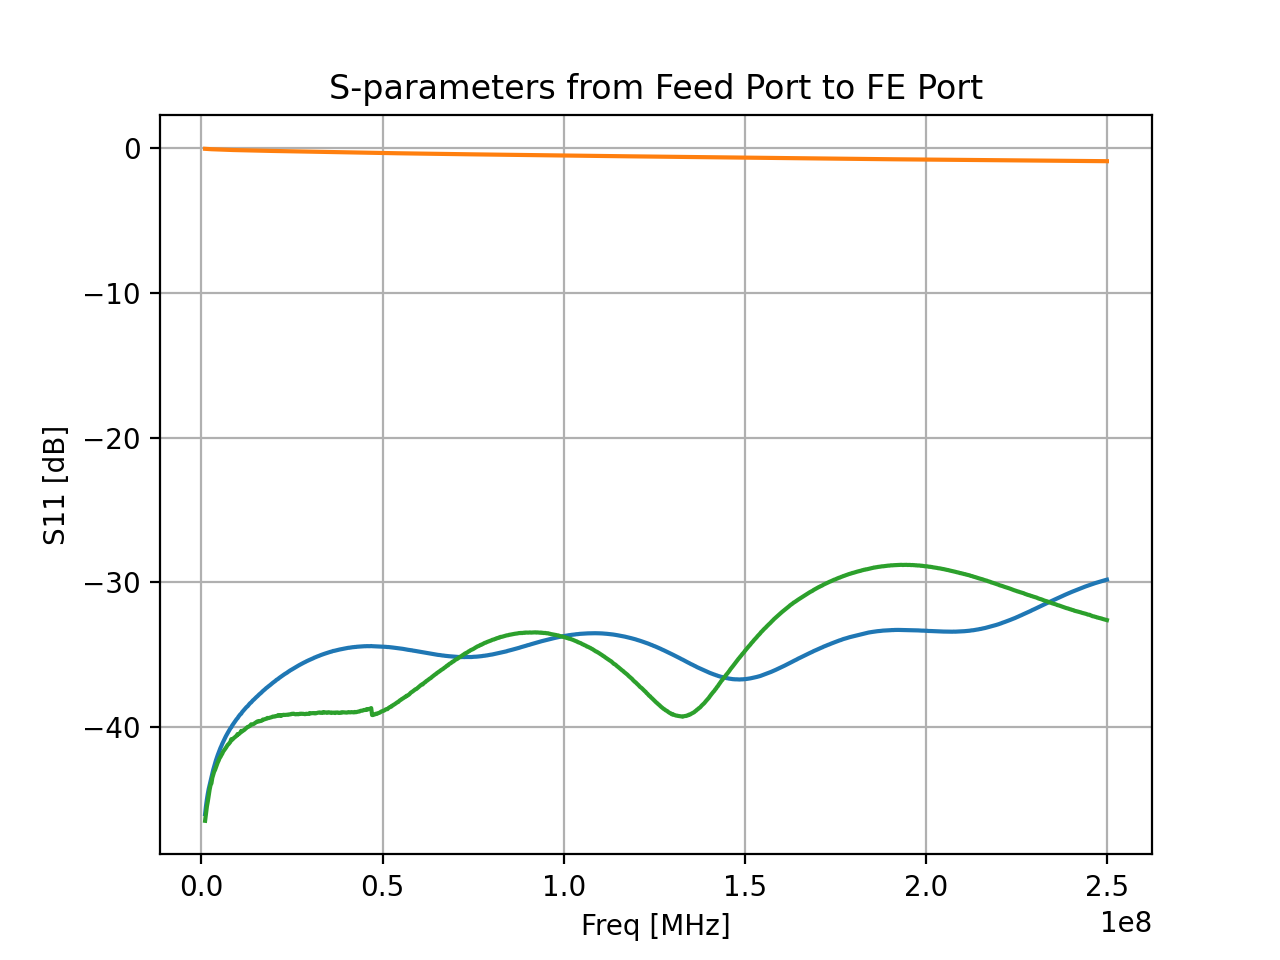

In [11]:
rfant_data = np.load('cable_measurements_0813/20250813_161614_vna_data.npz')
rfant = rfant_data['rfant']
rfant = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=rfant)
fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7))
ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

plt.suptitle('OSL Front End to Feed')
ax.plot(freqs/1e6, lin2dB(rfant.T))
ay.plot(freqs/1e6, np.angle(rfant).T)
plt.tight_layout()
plt.show()

rfant_sprms = kit.sparams(rfant)
plt.figure()
plt.grid()
plt.title('S-parameters from Feed Port to FE Port')
plt.xlabel('Freq [MHz]')
plt.ylabel('S11 [dB]')
plt.plot(freqs, lin2dB(rfant_sprms.T))
plt.show()

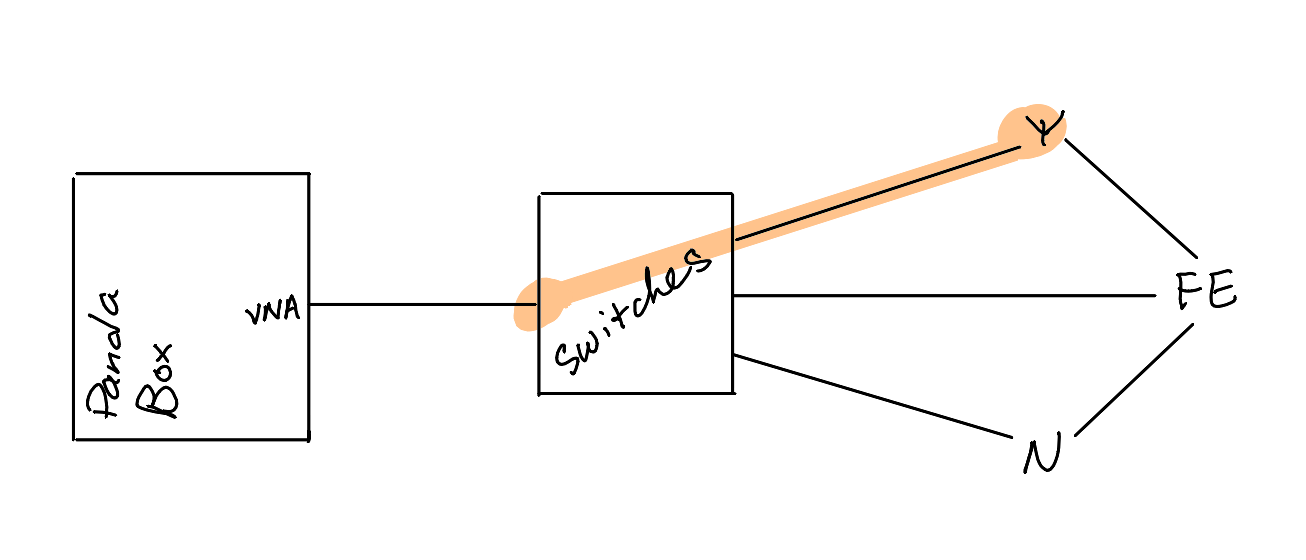

In [12]:
###CABLES BETWEEN VNA AND FEED###
from IPython.display import Image
Image(filename='ant_cables.png')

<IPython.core.display.Javascript object>


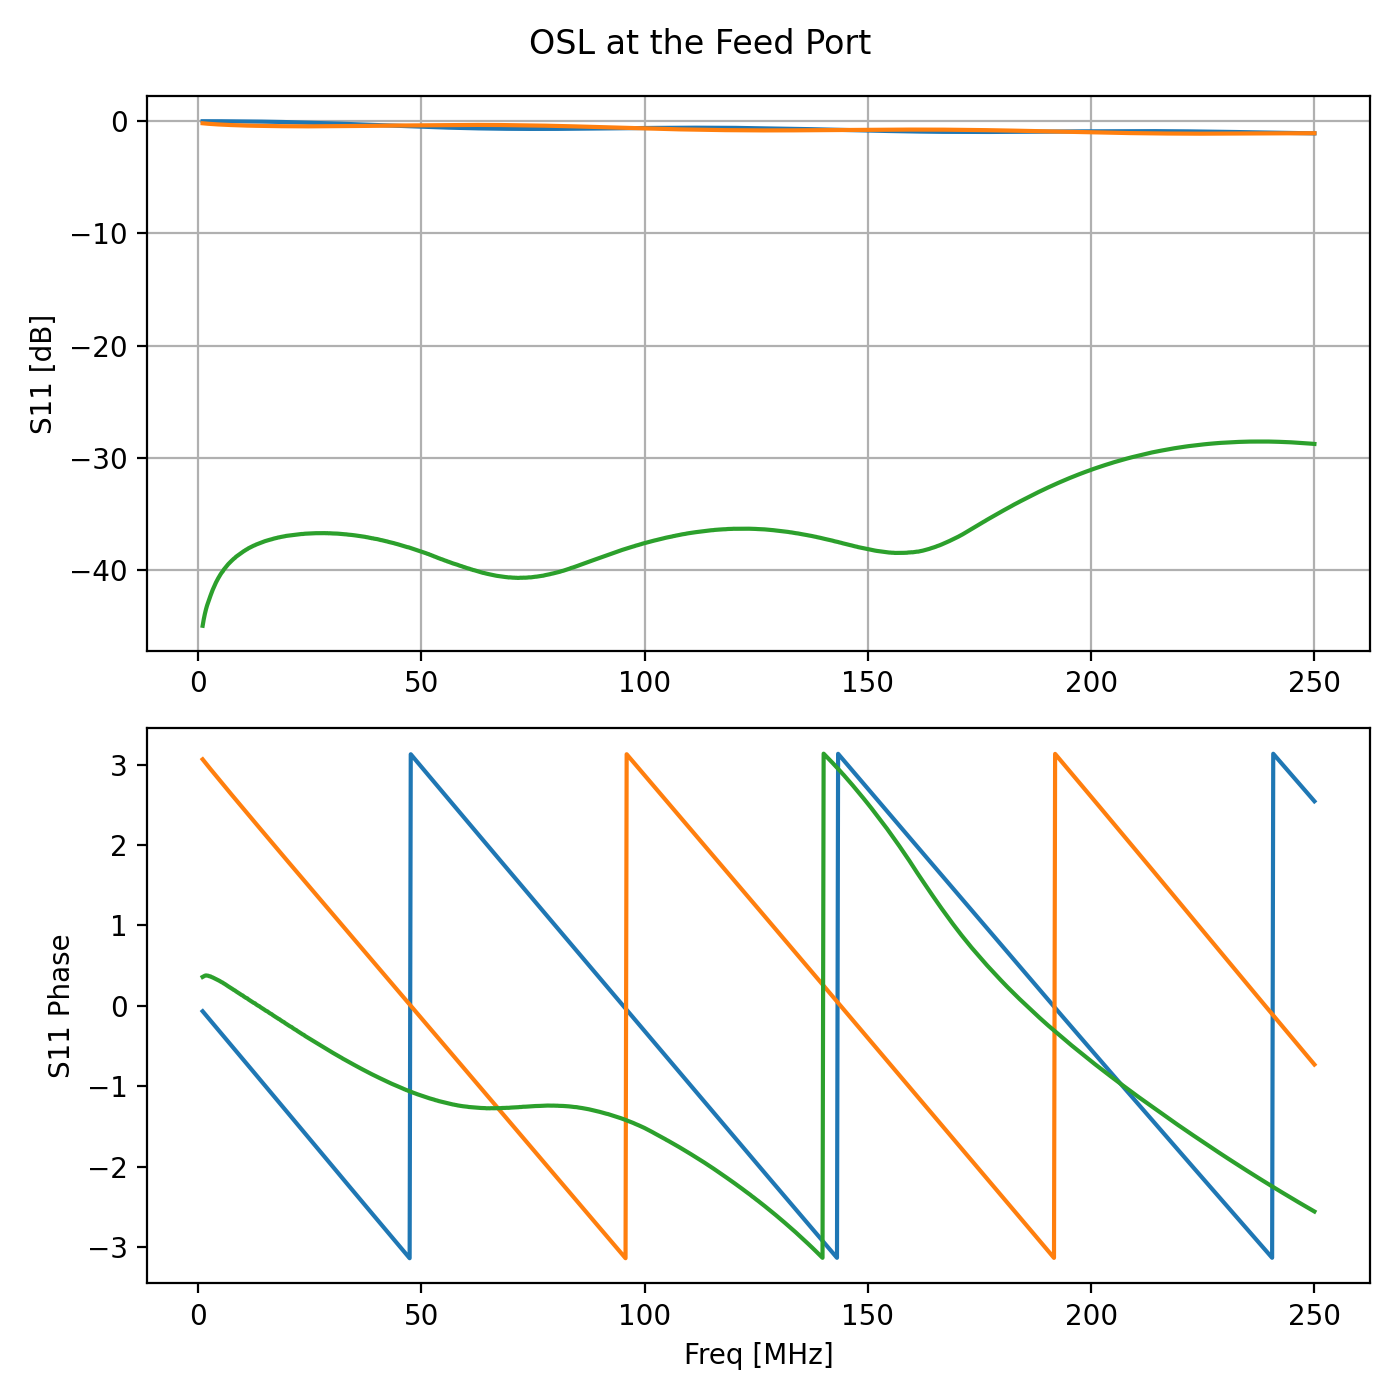

<IPython.core.display.Javascript object>


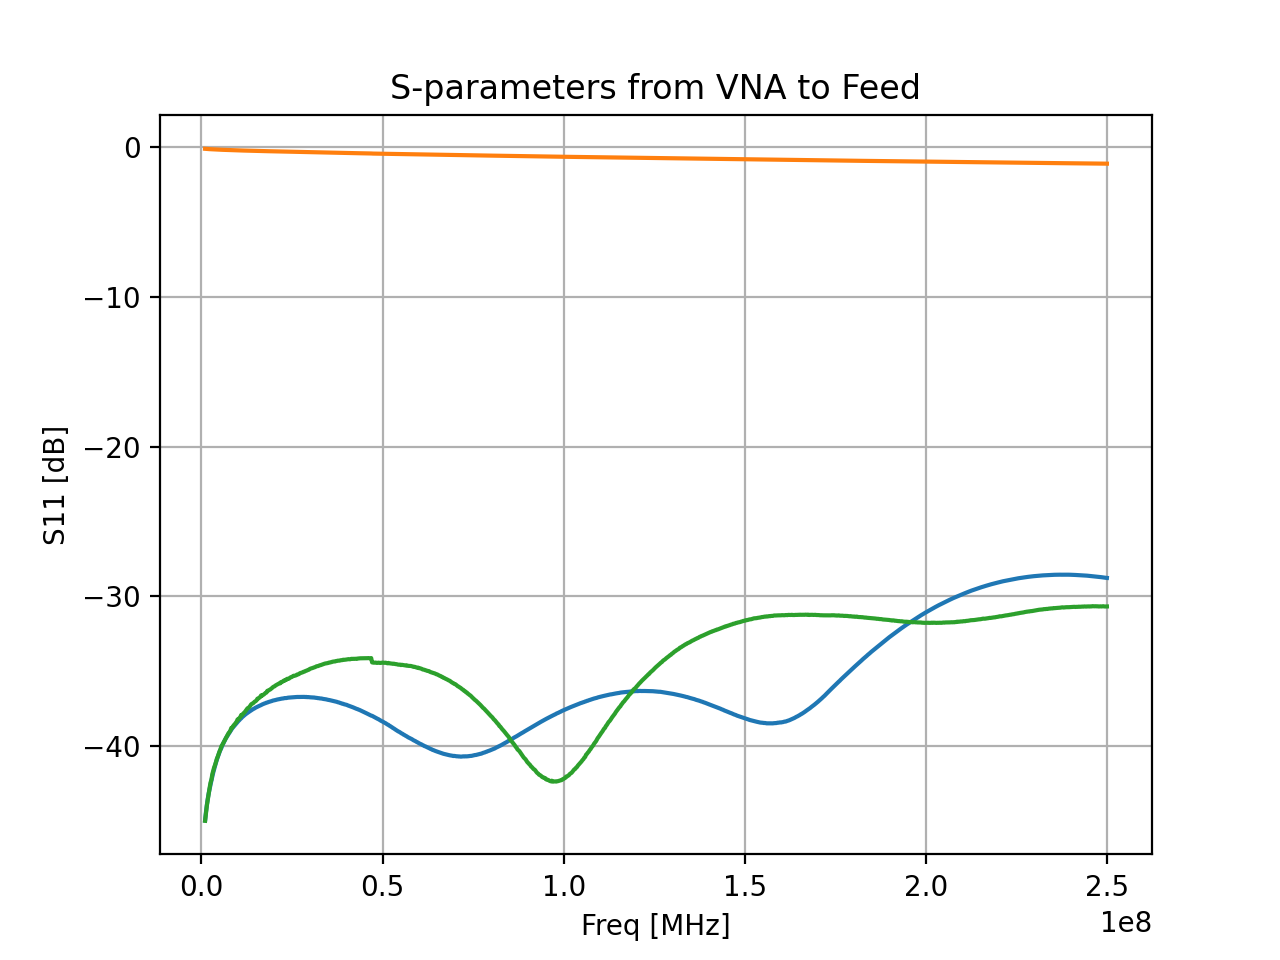

In [13]:
###CABLES BETWEEN FEED AND VNA###
ant_data = np.load('cable_measurements_0813/20250813_162207_vna_data.npz')
ant = ant_data['antenna_cables']
ant = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=ant)
fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7))
ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

plt.suptitle('OSL at the Feed Port')
ax.plot(freqs/1e6, lin2dB(ant.T))
ay.plot(freqs/1e6, np.angle(ant).T)
plt.tight_layout()
plt.show()

ant_cables_sprms = kit.sparams(ant)
plt.figure()

plt.title('S-parameters from VNA to Feed')
plt.xlabel('Freq [MHz]')
plt.ylabel('S11 [dB]')
plt.plot(freqs, lin2dB(ant_cables_sprms.T))
plt.grid()
plt.show()

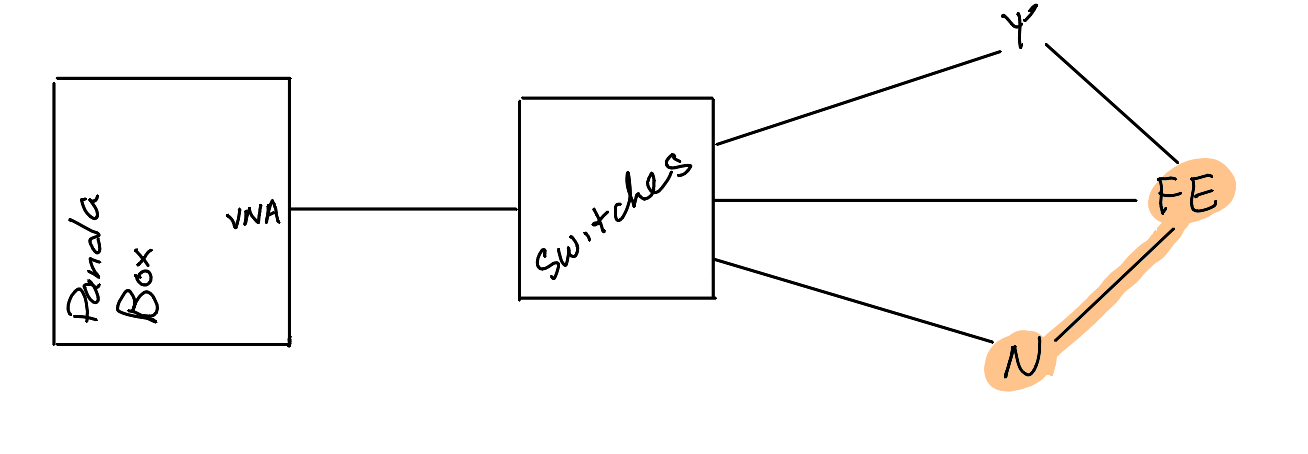

In [14]:
###CABLES BETWEEN FRONT END AND NOISE SOURCE###
from IPython.display import Image
Image(filename='rfns_cables.png')

<IPython.core.display.Javascript object>


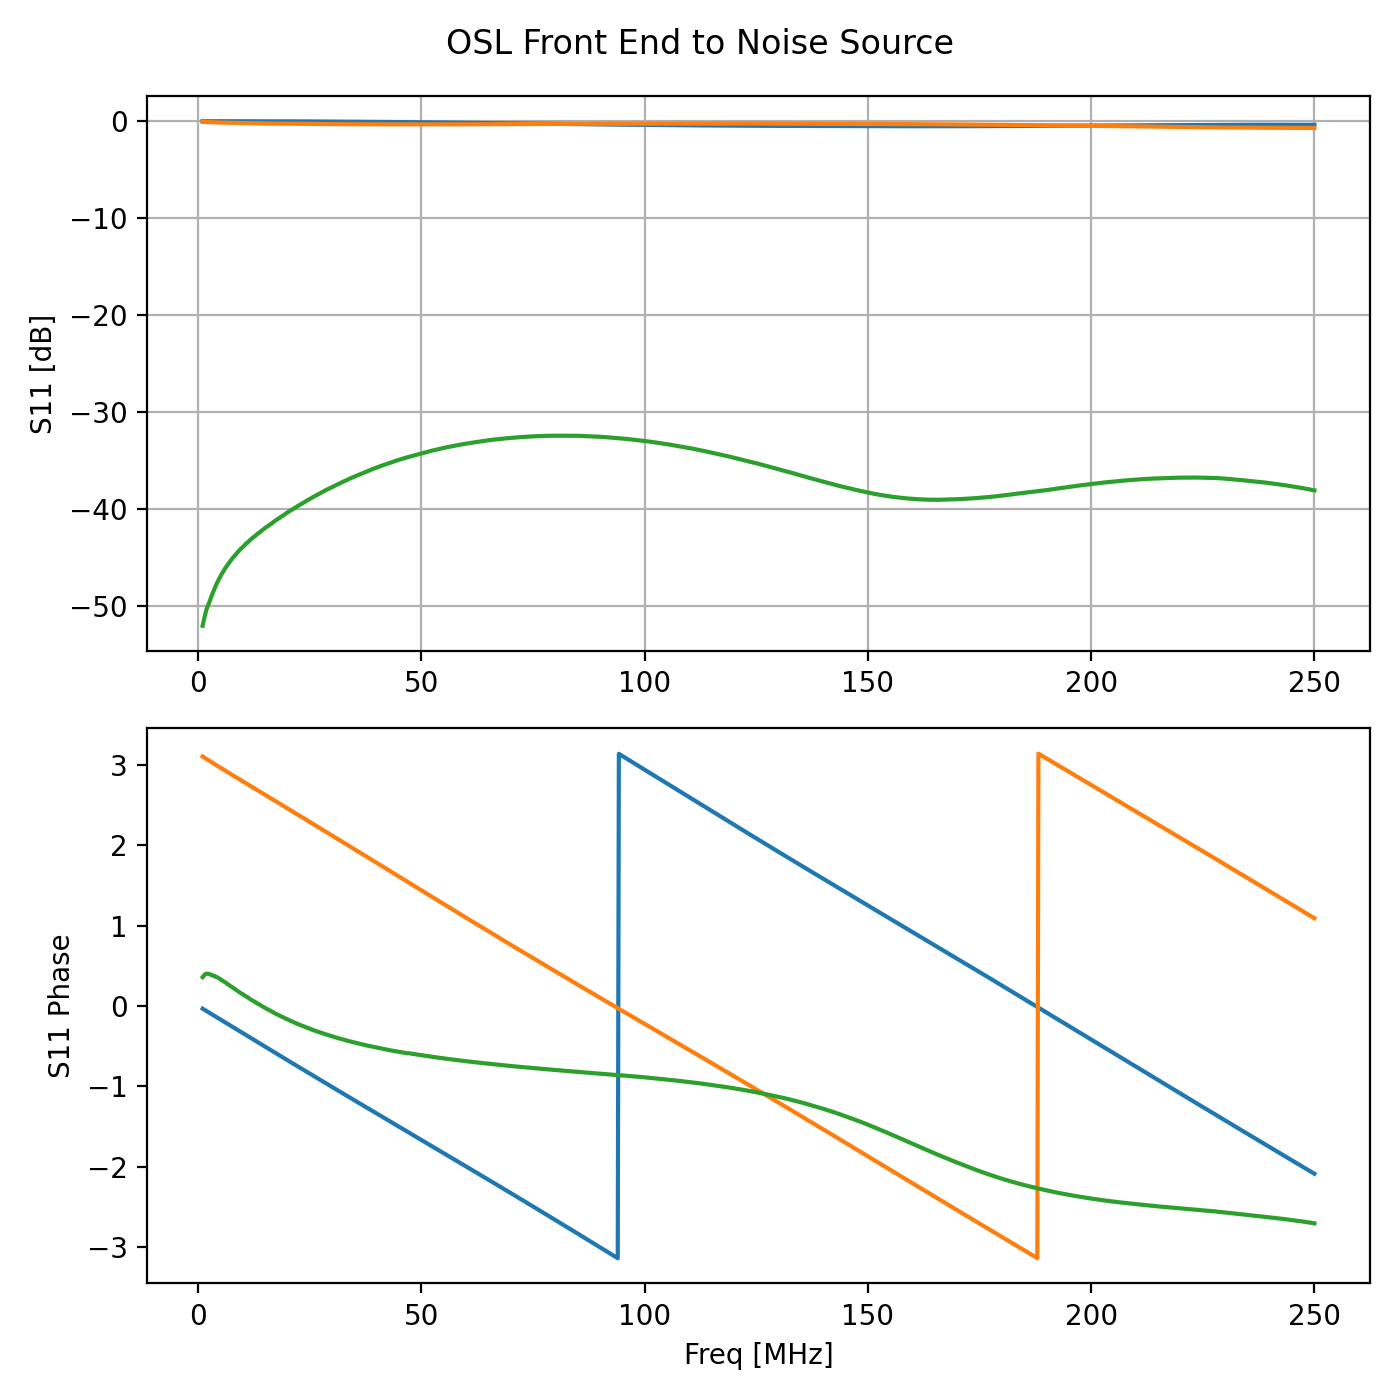

<IPython.core.display.Javascript object>


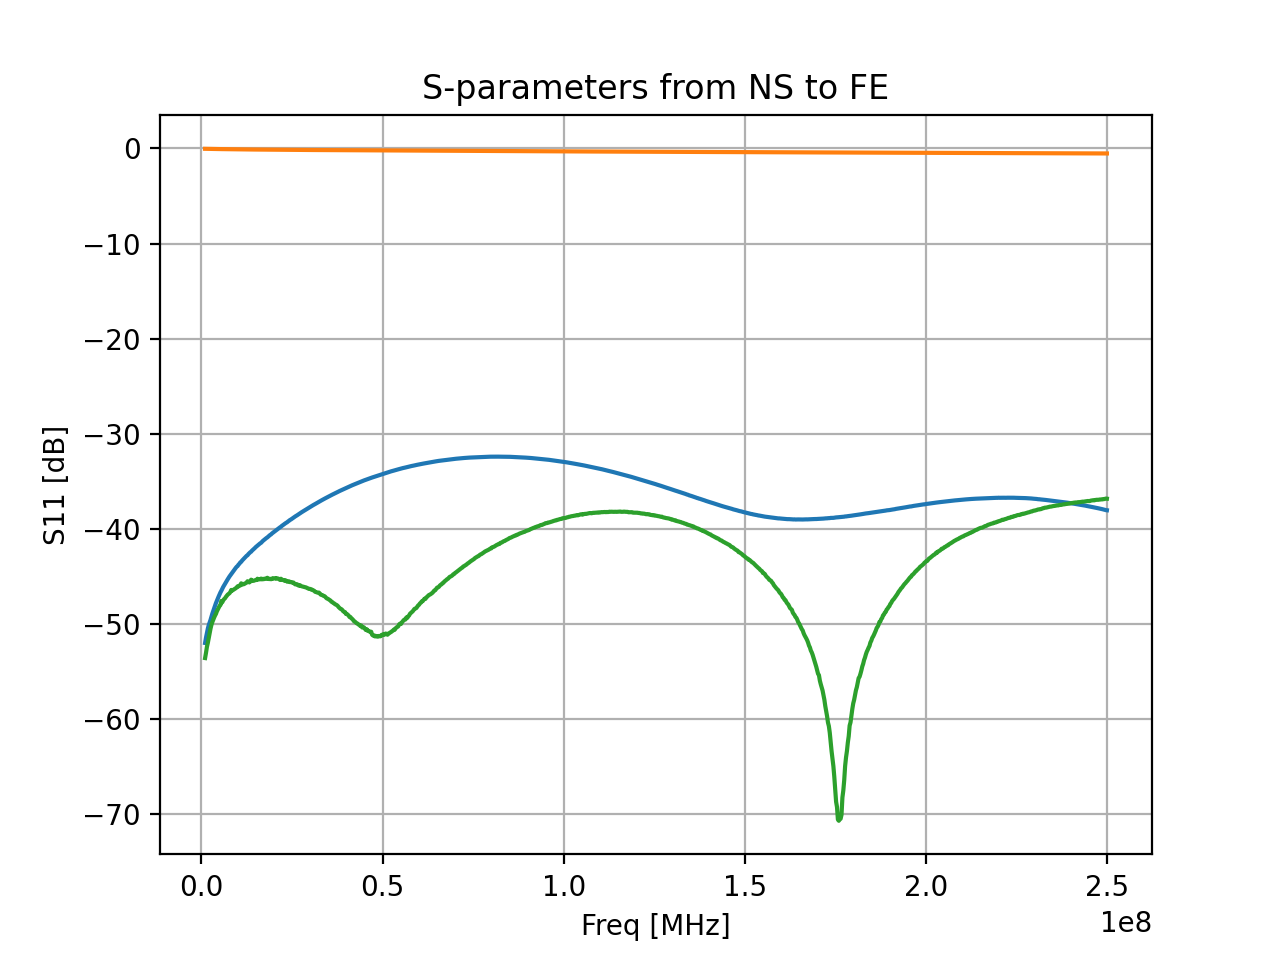

In [15]:
rfns_data = np.load('cable_measurements_0813/20250818_093413_vna_data.npz')
rfns = rfns_data['rfn_cables']
rfns = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=rfns)
fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7))
ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

plt.suptitle('OSL Front End to Noise Source')
ax.plot(freqs/1e6, lin2dB(rfns.T))
ay.plot(freqs/1e6, np.angle(rfns).T)
plt.tight_layout()
plt.show()

rfns_sprms = kit.sparams(rfns)
plt.figure()
plt.grid()
plt.title('S-parameters from NS to FE')
plt.xlabel('Freq [MHz]')
plt.ylabel('S11 [dB]')
plt.plot(freqs, lin2dB(rfns_sprms.T))
plt.show()

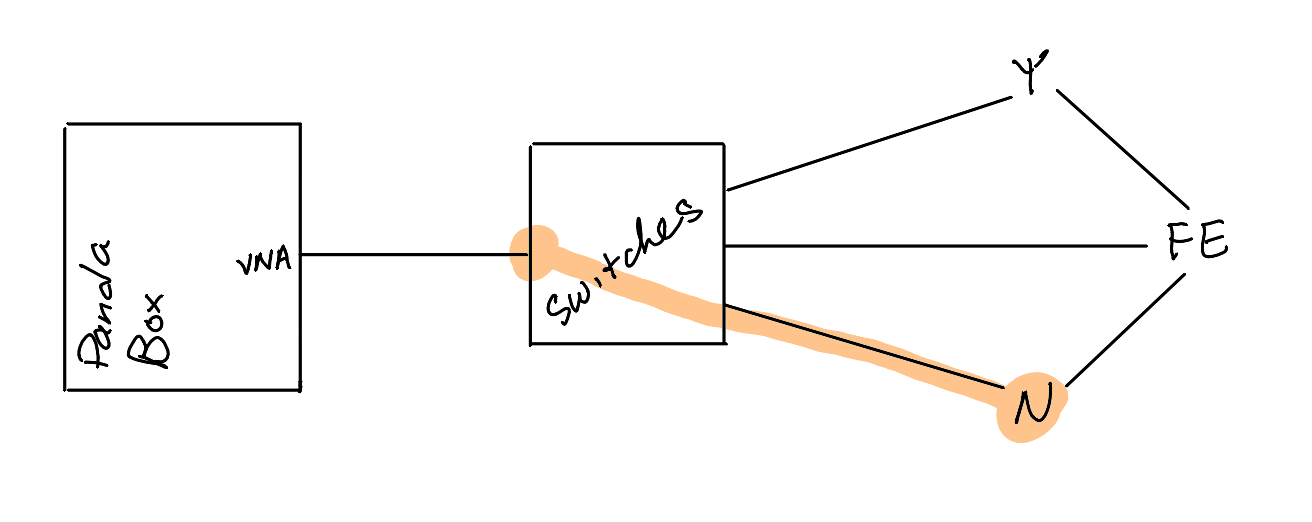

In [16]:
###CABLES BETWEEN VNA AND NOISE SOURCE###
from IPython.display import Image
Image(filename='ns_cables.png')

<IPython.core.display.Javascript object>


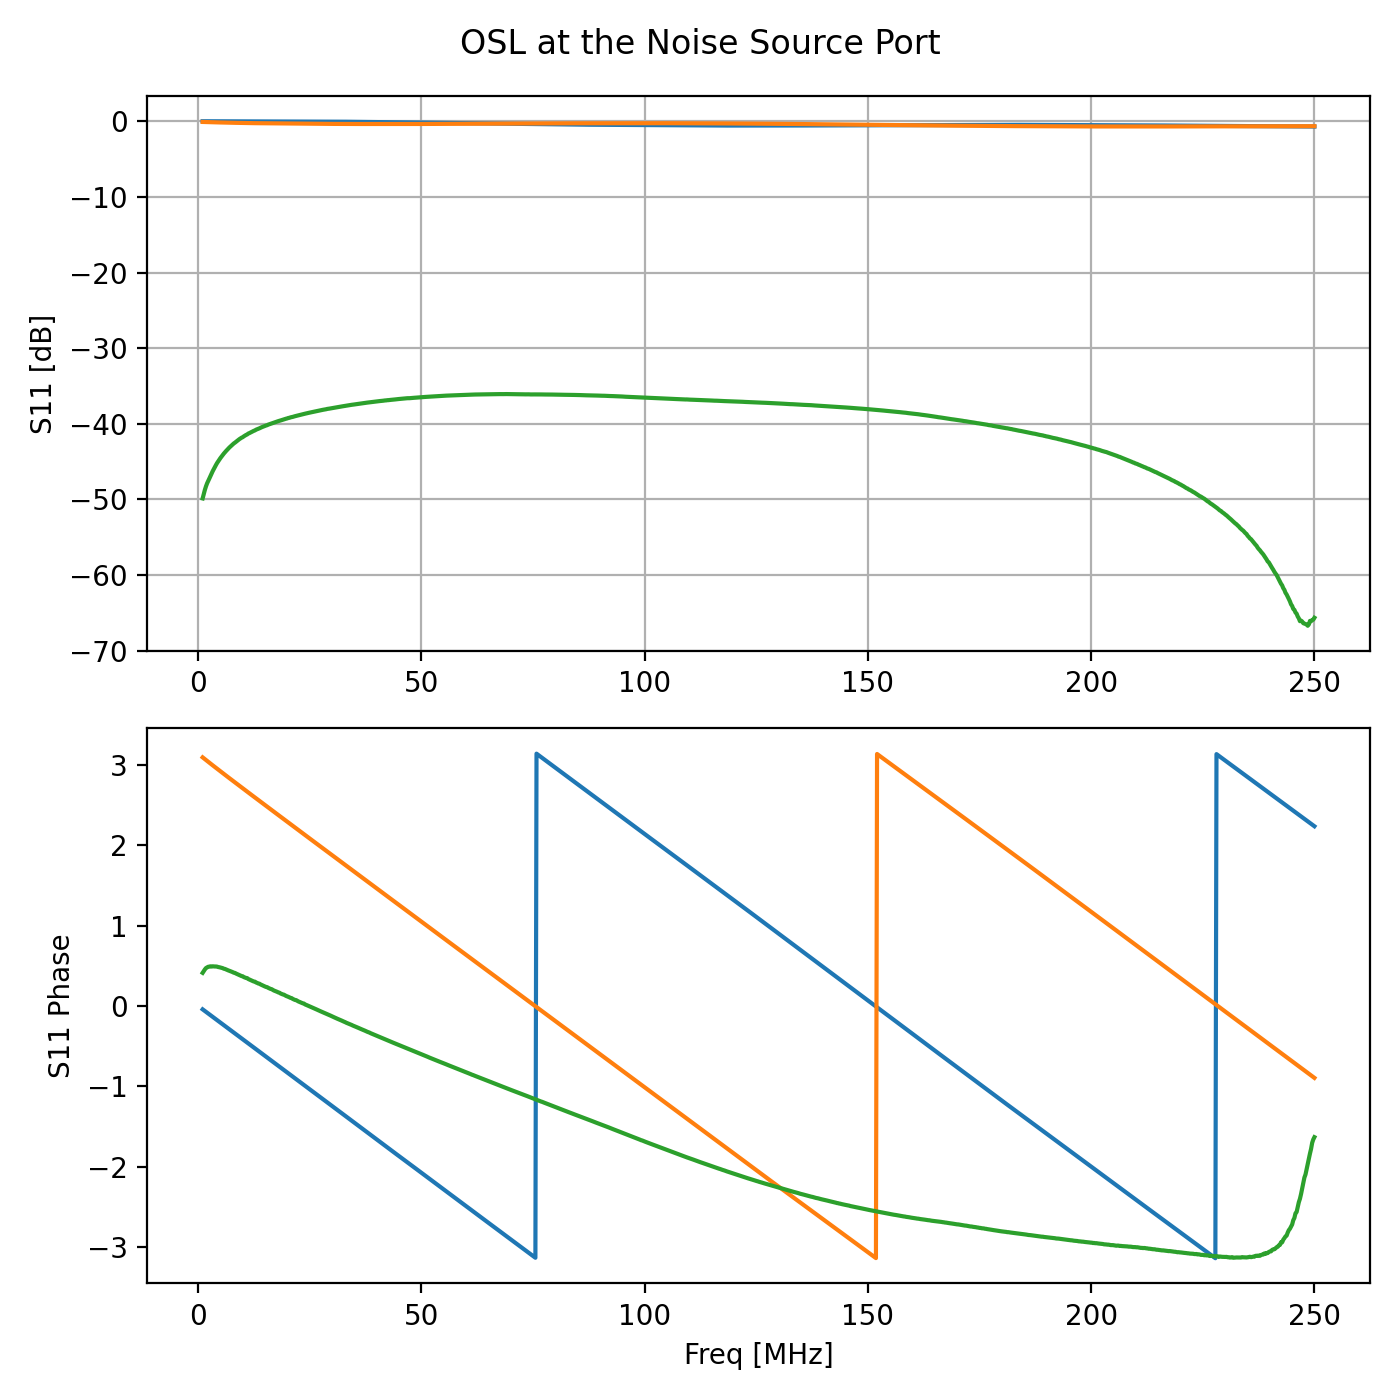

<IPython.core.display.Javascript object>


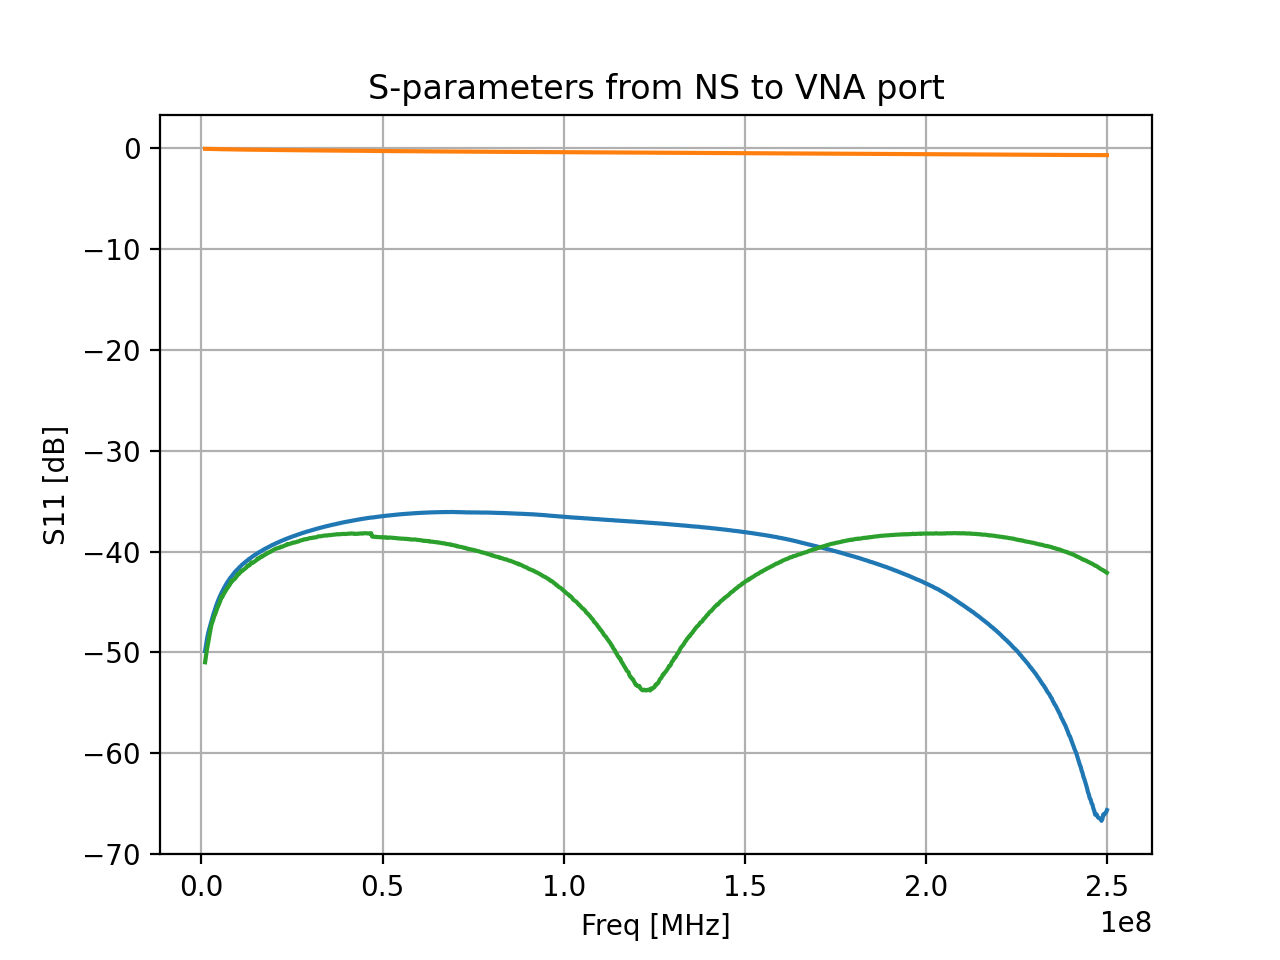

In [17]:
ns_data = np.load('cable_measurements_0813/20250818_093413_vna_data.npz')
ns = ns_data['ns_cables']
ns = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=ns)
fig, (ax, ay) = plt.subplots(2,1, figsize=(7,7))
ax.set_ylabel('S11 [dB]')
ax.grid()

ay.set_xlabel('Freq [MHz]')
ay.set_ylabel('S11 Phase')

plt.suptitle('OSL at the Noise Source Port')
ax.plot(freqs/1e6, lin2dB(ns.T))
ay.plot(freqs/1e6, np.angle(ns).T)
plt.tight_layout()
plt.show()

ns_cables_sprms = kit.sparams(ns)
plt.figure()

plt.title('S-parameters from NS to VNA port')
plt.xlabel('Freq [MHz]')
plt.ylabel('S11 [dB]')
plt.plot(freqs, lin2dB(ns_cables_sprms.T))
plt.grid()
plt.show()

# Calibrating a feed S11 from the field (Example)

<IPython.core.display.Javascript object>


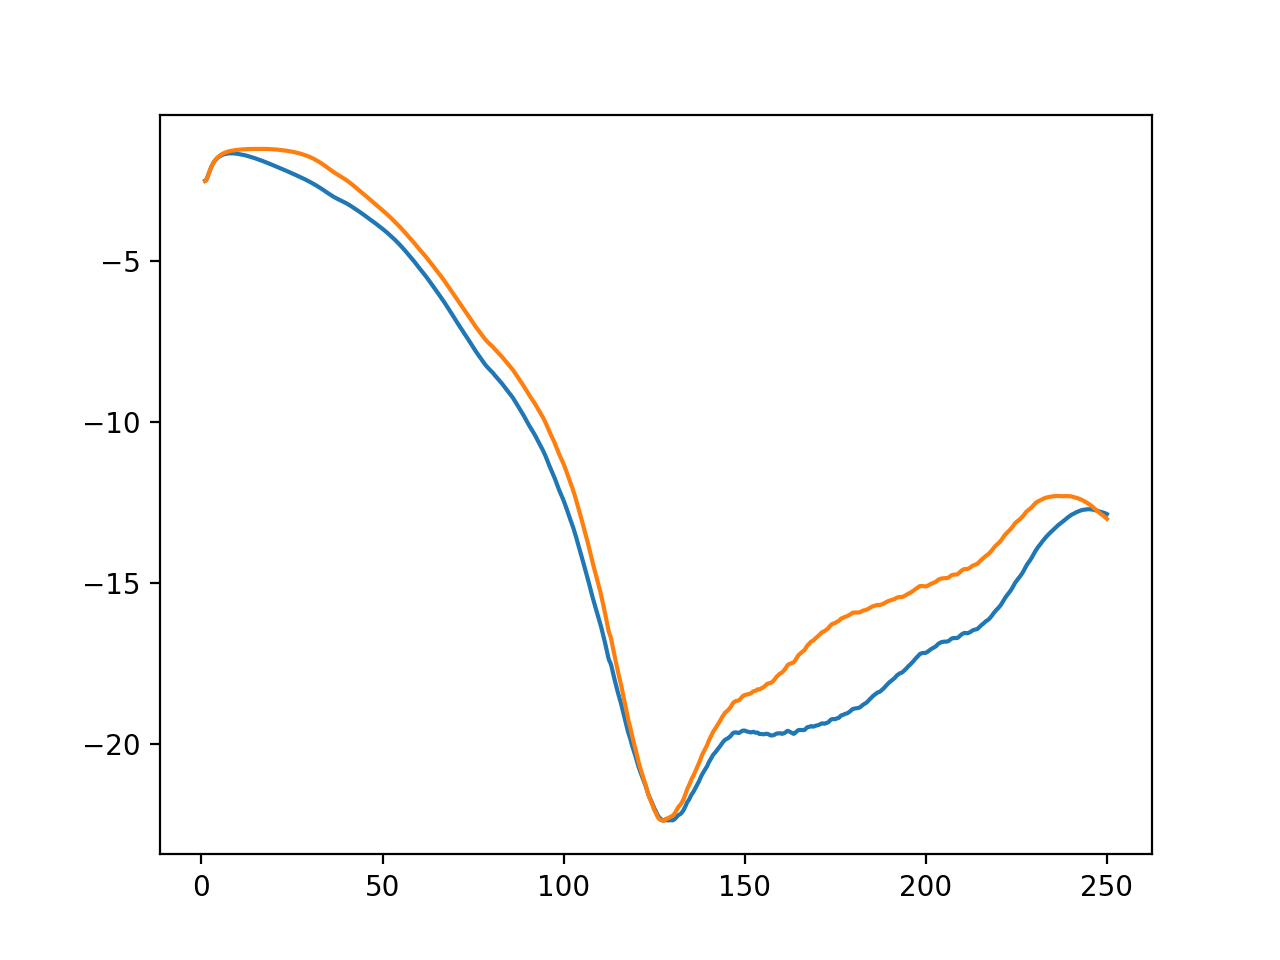

In [20]:
filename = '../july2025_S11/ants11_20250719_102527.h5'

def calibrate_feed(filename, return_vna_sprms=True):
    data, cal_data, header, metadata = obs.io.read_s11_file(filename)
    try:
        assert 'ant' in data.keys()
    except AssertionError:
        print('File does not contain correct data.')
        return
    
    ant, load, noise = data.values()
    l, o, s = cal_data.values()
    osl_meas = np.array([o,s,l])
    freqs = np.array(header['freqs'])
    
    vna_sprms = cal.network_sparams(gamma_true=data_kit.std_gamma, gamma_meas=osl_meas)
    
    at_vnaport = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=ant)
    at_feedport = cal.de_embed_sparams(sparams=ant_cables_sprms, gamma_prime=at_vnaport)
    
    if return_vna_sprms:
        return {'freqs': freqs, 'vna sparams': vna_sprms, 'uncalibrated':ant, 'calibrated': at_feedport}
    return {'freqs': freqs, 'uncalibrated':ant, 'calibrated': at_feedport}
    
a = calibrate_feed(filename=filename)
plt.figure()
plt.plot(a['freqs']/1e6, lin2dB(a['uncalibrated']).T)
plt.plot(a['freqs']/1e6, lin2dB(a['calibrated']).T)
plt.show()

# Calibration Procedure
    1. Calculate VNA+cable S-parameters by comparing in situ OSL measurements to those in fieldOSL_characterizations.npz.
    2. De-embed VNA+cable and feed cable from antenna S11 = calibrated feed S11.
    3. De-embed VNA+cable and front end cable from front end S11 = calibrated front end S11.
    4. De-embed VNA+cable and noise source cables from noise source S11 = calibrated noise source S11. 
    5. De-embed cal'ed feed S11 + cal'ed front end S11 + front-end to feed S-prms from spectra that correspond to this timestamp.
    6. Repeat 5 for noise source, on and off.
    7. Use cal'ed noise source spectrum to calibrate temperature.

In [21]:
np.savez('system_sparameters.npz', 
         ns_cables=ns_cables_sprms, 
         rfns_cables=rfns_sprms, 
         feed_cables=ant_cables_sprms, 
         rffeed_cables=rfant_sprms,
         rf_cables=rf_cables_sprms)